Sentiment Analysis with RNNs
============================

This notebook is part of a series:

- Sentiment Analysis with RNNs - Disaster Tweets
- Sentiment Analysis with RNNs - TripAdvisor Reviews
- Sentiment Analysis with RNNs - News Headlines Sarcasm

In this notebook we reviewed some techniques to perform sentiment analysis on a text dataset.
We have found 4 different datasets on which we could conduct a sentiment analysis, each one containing a text and a sentiment (positive or negative).

- [IMDB Movies Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
- [Disaster tweets dataset](https://www.kaggle.com/competitions/nlp-getting-started)
- [Tripadvisor reviews](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)
- [News headlines sarcasm detection](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

This problem can be formulated as a binary classification of a text, based on the sentiment associated to each word and their structure in the sentence.

<a id="toc">Table of Contents</a>

1. [Data Analysis](#1)
    [a. Dataset info](#1a)
    [b. Dirty characters](#1b)
2. [Text Preprocessing](#2a)
3. [Model Experiments](#3)
    [a. Simple FFN](#3a)
    [b. Simple RNN](#3b)
    [c. LSTM](#3c)
    [d. GRU](#3d)
    [e. 2 Layers LSTM](#3e)
4. [Embedding Experiments](#4)
    [a. LSTM - GloVe 6B300D](#4a)
    [b. GRU - GloVe 6B300D](#4b)
    [c. LSTM - GloVe Twitter 27B200D](#4c)
    [d. GRU - GloVe 27B200D](#4d)
5. [Contextual Embeddings](#5)

In [7]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#Uncomment the desired dataset

##IMDB dataset
#imdb_path = '../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
# data = pd.read_csv(imdb_path)
# X = data['review']
# y = pd.Series(np.where(data['sentiment'].str.contains("positive"), 1, 0))

##Disaster tweets dataset
# dis_path = '../input/nlp-getting-started/train.csv'
# data  = pd.read_csv(dis_path)
# X = data['text']
# y = data['target']

##TripAdvisor reviews
# trip_path = '../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
# data = pd.read_csv(trip_path)
# X = data['Review']
# y = pd.Series(np.where(data['Rating'] >3, 1, 0))

##News headlines sarcasm detection
news_path = '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'
data = pd.read_json(news_path, lines=True)
X = data['headline']
y = data['is_sarcastic']

# print(data.columns)
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB
None


# 1. Data Analysis
<a href="#toc" id="1">Table Of Contents</a>

First we determine if our dataset is balanced or not between positive and negative examples

0    14985
1    11724
Name: is_sarcastic, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


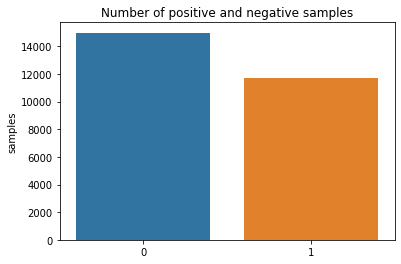

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

y_count =y.value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('Number of positive and negative samples')

print(y_count)

The News headlines dataset is slightly unbalanced, with positive examples (News with sarcasm) being the 40% of the total.

## Characters/Words count
<a href="#toc" id="1a">Table Of Contents</a>

We can use some histograms to determine how the character and word count of the samples is distributed, in samples with positive or negative sentiment. Are positive or negative samples distributed in the same way or there is a difference in length?

254
62


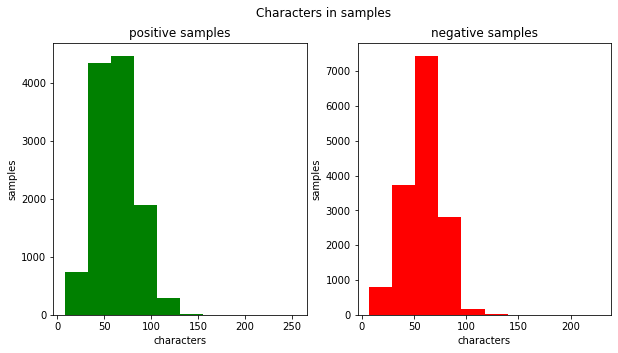

In [9]:
import math
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
X_len=X[y==1].str.len()
ax1.hist(X_len,color='green')
ax1.set_ylabel('samples')
ax1.set_xlabel('characters')
ax1.set_title('positive samples')

print(max(X_len))
print(int(X_len.mean()))

X_len=X[y==0].str.len()
ax2.hist(X_len,color='red')
ax2.set_ylabel('samples')
ax2.set_xlabel('characters')
ax2.set_title('negative samples')
fig.suptitle('Characters in samples')
plt.show()


Titles have an average length of 62 characters, with a maximum length of 254.

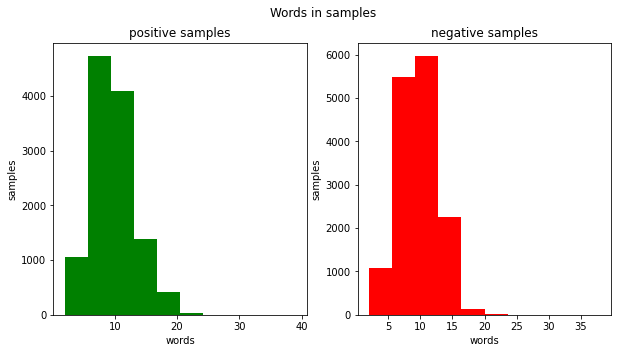

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
X_len=X[y==1].str.split().map(lambda x: len(x))
ax1.hist(X_len,color='green')
ax1.set_ylabel('samples')
ax1.set_xlabel('words')
ax1.set_title('positive samples')
X_len=X[y==0].str.split().map(lambda x: len(x))
ax2.hist(X_len,color='red')
ax2.set_ylabel('samples')
ax2.set_xlabel('words')
ax2.set_title('negative samples')
fig.suptitle('Words in samples')
plt.show()

## Dirty characters
<a href="#toc" id="1b">Table Of Contents</a>

Some datasets can contain samples with some dirty characters.
- HTML tags
- Links
- Hashtags
- Emoticons (both in single character :smile: or with composed characters :) )
- Non-ascii characters

Those characters have been removed to improve the quality of the dataset and obtain overall better results.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


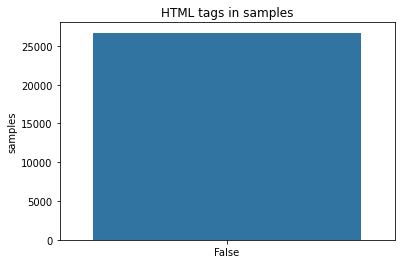

In [11]:
y_count = X.str.contains('<.*?>', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('HTML tags in samples')

X = X.str.replace(r'<.*?>','', regex= True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


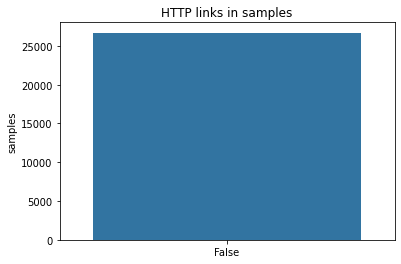

In [12]:
y_count = X.str.contains('http://+', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('HTTP links in samples')

X = X.str.replace(r'http://+','', regex= True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


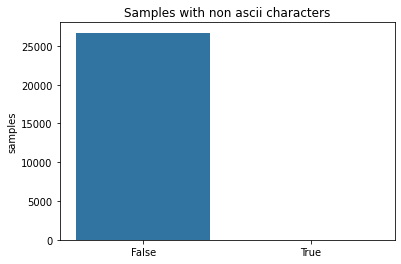

In [13]:
y_count = X.str.contains('[^[:ascii:]]', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('Samples with non ascii characters')

# print(X[X.str.contains('[^[:ascii:]]', regex= True, na=False)])
# print(X[49677])

X = X.str.replace(r'[^[:ascii:]]','', regex= True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


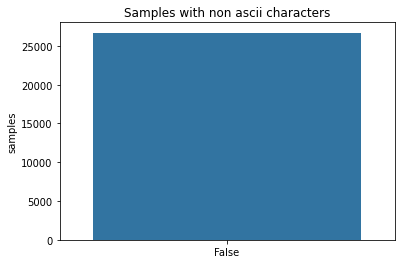

In [14]:
y_count = X.str.contains('&/?[a-z]+;', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('Samples with non ascii characters')

X = X.str.replace(r'&/?[a-z]+;','', regex= True)

# Text preprocessing
<a href="#toc" id="2">Table Of Contents</a>

Before feeding the text to the model, it needs to be tokenized.
I used the most basic [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to create the vocabulary using the train dataset, and then proceed to tokenize the train and test dataset.
There are a few parameters to decide
* Vocabulary size
* Dimension of the embedding: usually between 100 and 300
* Maximum length(in characters)
* What to do with sentences shorter or longer than maximum length
* Further reduction of the vocabulary with lemmatization or stemming.

We took a vocabulary of 1000 words, and chose a max length of 25, in accord with the size of the titles.
Longer titles may be truncated, while shorter have been padded to reach an equal size of each batch. More advanced techniques may use dynamic batching, where maximum size is inferred in each batch and samples are padded accordingly.
Stemming was done with ``PorterStemmer``.

In [15]:
import nltk
import pandas as pd
import numpy as np
import re
from nltk.stem.porter import *

wpt = nltk.WordPunctTokenizer()

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')


vocab_size = 1000
embedding_dim = 300
max_length = 25
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

stemmer = PorterStemmer()

STEMMING = True
BATCH_SIZE = 64

def normalize_and_tokenize(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s!]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    if STEMMING:
        filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]
    # re-create document from filtered tokens
    return ' '.join(filtered_tokens)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


With a WordCloud we visualize the most frequent words, we'd like that stopwords or dirty characters were not shown here

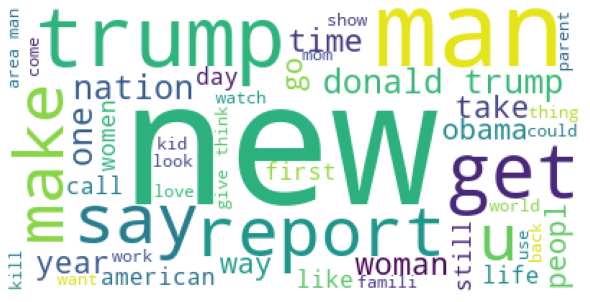

In [16]:
from wordcloud import WordCloud


X = X.map(normalize_and_tokenize)
wordcloud = WordCloud(
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(" ".join(X.to_list()))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

tokenizer = Tokenizer(num_words = vocab_size
                      ,oov_token=oov_tok
                     )

tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [21]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
train_padded = np.array(train_padded)
train_labels = np.array(y_train)
test_padded = np.array(test_padded)
test_labels = np.array(y_test)

In [22]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Model Experiments
<a href="#toc" id="3">Table Of Contents</a>
## Simple Feed Forward Network
<a href="#toc" id="3a"></a>

In [23]:
from tensorflow.keras.optimizers import SGD, Adam
optimizer=Adam(learning_rate=1e-4)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

2022-07-22 14:25:10.287251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:25:10.408132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:25:10.408866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:25:10.410041: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          300000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                7224      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 307,249
Trainable params: 307,249
Non-trainable params: 0
_________________________________________________________________


node zero
2022-07-22 14:25:10.411019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:25:10.411655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:25:12.763287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:25:12.764112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:25:12.764790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

### Training

2022-07-22 14:25:13.208451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
334/334 - 3s - loss: 0.6885 - accuracy: 0.5577 - val_loss: 0.6855 - val_accuracy: 0.5629
Epoch 2/40
334/334 - 1s - loss: 0.6864 - accuracy: 0.5606 - val_loss: 0.6847 - val_accuracy: 0.5629
Epoch 3/40
334/334 - 1s - loss: 0.6859 - accuracy: 0.5606 - val_loss: 0.6843 - val_accuracy: 0.5629
Epoch 4/40
334/334 - 1s - loss: 0.6855 - accuracy: 0.5606 - val_loss: 0.6839 - val_accuracy: 0.5629
Epoch 5/40
334/334 - 1s - loss: 0.6847 - accuracy: 0.5606 - val_loss: 0.6830 - val_accuracy: 0.5629
Epoch 6/40
334/334 - 1s - loss: 0.6843 - accuracy: 0.5606 - val_loss: 0.6824 - val_accuracy: 0.5629
Epoch 7/40
334/334 - 1s - loss: 0.6823 - accuracy: 0.5606 - val_loss: 0.6808 - val_accuracy: 0.5629
Epoch 8/40
334/334 - 1s - loss: 0.6802 - accuracy: 0.5610 - val_loss: 0.6783 - val_accuracy: 0.5629
Epoch 9/40
334/334 - 1s - loss: 0.6778 - accuracy: 0.5626 - val_loss: 0.6754 - val_accuracy: 0.5629
Epoch 10/40
334/334 - 1s - loss: 0.6742 - accuracy: 0.5681 - val_loss: 0.6729 - val_accuracy: 0.5706

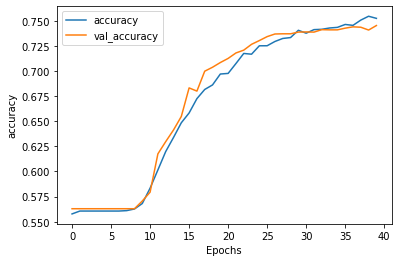

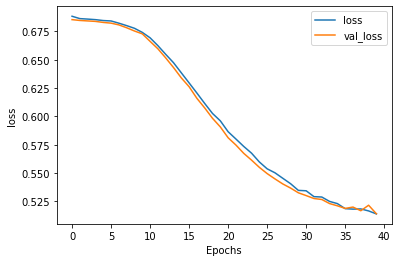

In [25]:
num_epochs = 40
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), batch_size = BATCH_SIZE, verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Recurrent Neural Networks
<a href="#toc" id="3b">Table Of Contents</a>

For now disabled, they require too much time for training.
In addition, simple RNNs are subjected to vanishing gradient and the context is limited to a few time steps.

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True,input_shape=(max_length, embedding_dim))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          300000    
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 100)          35100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
flatten (Flatten)            (None, 15000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15001     
Total params: 350,101
Trainable params: 350,101
Non-trainable params: 0
_________________________________________________________________


In [27]:
# num_epochs = 5
# history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)
# plot_graphs(history, "accuracy")
# plot_graphs(history, "loss")

## LSTMs
<a href="#toc" id="3c">Table Of Contents</a>

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 300)          300000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 64)           85248     
_________________________________________________________________
dense_3 (Dense)              (None, 150, 24)           1560      
_________________________________________________________________
dense_4 (Dense)              (None, 150, 1)            25        
Total params: 386,833
Trainable params: 386,833
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40


2022-07-22 14:26:04.579479: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


334/334 - 10s - loss: 0.6851 - accuracy: 0.5647 - val_loss: 0.6803 - val_accuracy: 0.5789
Epoch 2/40
334/334 - 6s - loss: 0.6029 - accuracy: 0.6990 - val_loss: 0.6380 - val_accuracy: 0.6485
Epoch 3/40
334/334 - 6s - loss: 0.5833 - accuracy: 0.7101 - val_loss: 0.5804 - val_accuracy: 0.7185
Epoch 4/40
334/334 - 6s - loss: 0.5621 - accuracy: 0.7377 - val_loss: 0.6319 - val_accuracy: 0.7251
Epoch 5/40
334/334 - 6s - loss: 0.5537 - accuracy: 0.7550 - val_loss: 0.5685 - val_accuracy: 0.7400
Epoch 6/40
334/334 - 6s - loss: 0.5427 - accuracy: 0.7633 - val_loss: 0.5897 - val_accuracy: 0.7221
Epoch 7/40
334/334 - 6s - loss: 0.5575 - accuracy: 0.7371 - val_loss: 0.5837 - val_accuracy: 0.7068
Epoch 8/40
334/334 - 6s - loss: 0.5456 - accuracy: 0.7575 - val_loss: 0.5679 - val_accuracy: 0.7437
Epoch 9/40
334/334 - 6s - loss: 0.5387 - accuracy: 0.7663 - val_loss: 0.5655 - val_accuracy: 0.7415
Epoch 10/40
334/334 - 6s - loss: 0.5394 - accuracy: 0.7641 - val_loss: 0.5702 - val_accuracy: 0.7289
Epoch 11/

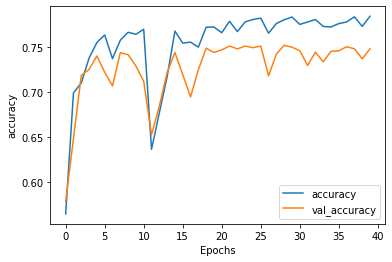

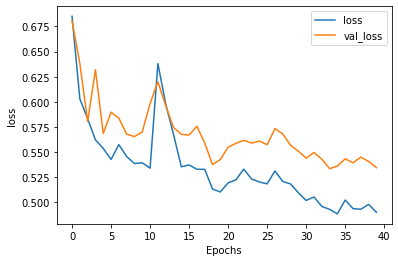

In [29]:
num_epochs = 40
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=39)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels),batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## GRUs
<a href="#toc" id="3d">Table Of Contents</a>

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 300)          300000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 64)           64128     
_________________________________________________________________
dense_5 (Dense)              (None, 150, 1)            65        
Total params: 364,193
Trainable params: 364,193
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
334/334 - 8s - loss: 0.6857 - accuracy: 0.5636 - val_loss: 0.6838 - val_accuracy: 0.5669
Epoch 2/40
334/334 - 5s - loss: 0.6827 - accuracy: 0.5686 - val_loss: 0.6709 - val_accuracy: 0.5894
Epoch 3/40
334/334 - 5s - loss: 0.5830 - accuracy: 0.7253 - val_loss: 0.5742 - val_accuracy: 0.7328
Epoch 4/40
334/334 - 5s - loss: 0.5510 - accuracy: 0.7533 - val_loss: 0.5691 - val_accuracy: 0.7316
Epoch 5/40
334/334 - 5s - loss: 0.5523 - accuracy: 0.7399 - val_loss: 0.5783 - val_accuracy: 0.6993
Epoch 6/40
334/334 - 5s - loss: 0.5534 - accuracy: 0.7439 - val_loss: 0.5759 - val_accuracy: 0.7155
Epoch 7/40
334/334 - 5s - loss: 0.5443 - accuracy: 0.7520 - val_loss: 0.5802 - val_accuracy: 0.7221
Epoch 8/40
334/334 - 5s - loss: 0.5369 - accuracy: 0.7598 - val_loss: 0.5771 - val_accuracy: 0.7424
Epoch 9/40
334/334 - 5s - loss: 0.5298 - accuracy: 0.7680 - val_loss: 0.5543 - val_accuracy: 0.7466
Epoch 10/40
334/334 - 6s - loss: 0.5264 - accuracy: 0.7689 - val_loss: 0.5574 - val_accuracy: 0.7411

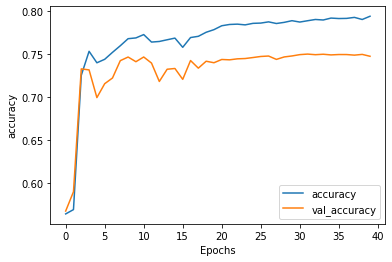

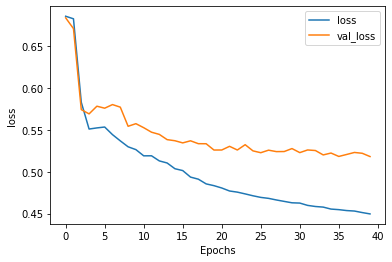

In [31]:
num_epochs = 40
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels),batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## 2 Layers
<a href="#toc" id="3e">Table Of Contents</a>

We also tried a more complex model with 2 bidirectional LSTM layers

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,dropout=0.5)),
#   tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 300)          300000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150, 64)           85248     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 150, 64)           24832     
_________________________________________________________________
dense_6 (Dense)              (None, 150, 24)           1560      
_________________________________________________________________
dense_7 (Dense)              (None, 150, 1)            25        
Total params: 411,665
Trainable params: 411,665
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
668/668 - 22s - loss: 0.6836 - accuracy: 0.5663 - val_loss: 0.6366 - val_accuracy: 0.6454
Epoch 2/40
668/668 - 17s - loss: 0.6042 - accuracy: 0.6849 - val_loss: 0.5879 - val_accuracy: 0.7293
Epoch 3/40
668/668 - 17s - loss: 0.5675 - accuracy: 0.7390 - val_loss: 0.6110 - val_accuracy: 0.6822
Epoch 4/40
668/668 - 17s - loss: 0.5625 - accuracy: 0.7130 - val_loss: 0.5550 - val_accuracy: 0.7343
Epoch 5/40
668/668 - 17s - loss: 0.5441 - accuracy: 0.7451 - val_loss: 0.5658 - val_accuracy: 0.7292
Epoch 6/40
668/668 - 17s - loss: 0.5298 - accuracy: 0.7430 - val_loss: 0.5405 - val_accuracy: 0.7212
Epoch 7/40
668/668 - 17s - loss: 0.5250 - accuracy: 0.7284 - val_loss: 0.5565 - val_accuracy: 0.6803
Epoch 8/40
668/668 - 17s - loss: 0.5183 - accuracy: 0.7286 - val_loss: 0.5361 - val_accuracy: 0.7240
Epoch 9/40
668/668 - 17s - loss: 0.5133 - accuracy: 0.7585 - val_loss: 0.5448 - val_accuracy: 0.7405
Epoch 10/40
668/668 - 17s - loss: 0.5081 - accuracy: 0.7636 - val_loss: 0.5341 - val_accura

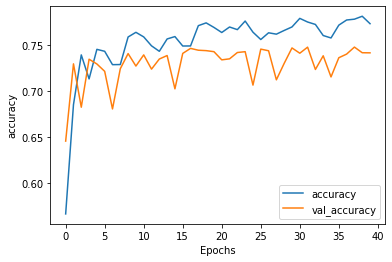

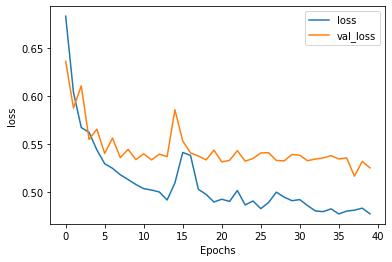

In [33]:
num_epochs = 40
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# **GloVe pretrained word embeddings - text-preprocessing WITHOUT stemming**
<a href="toc" id="4"></a>

**text pre-processing**

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# TEXT PRE-PROCESSING WITHOUT STEMMING
 
# import nltk
# import re
# from nltk.stem.porter import *


# nltk.download('stopwords')

# wpt = nltk.WordPunctTokenizer()
# stop_words = nltk.corpus.stopwords.words('english')

# vocab_size = 1000
# embedding_dim = 300
# max_length = 1000
# trunc_type='post'
# padding_type='post'
# oov_tok = "<UNK>"

STEMMING = False
X = X.map(normalize_and_tokenize)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

tokenizer = Tokenizer(num_words = vocab_size
                      ,oov_token= oov_tok
                     )
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

import numpy as np
train_padded = np.array(train_padded)
train_labels = np.array(y_train)
test_padded = np.array(test_padded)
test_labels = np.array(y_test)


## **LSTMs**
<a href="#toc" id="4a">Table Of Contents</a>

**import pre-trained static embeddings**

In [35]:
# load the GloVe embedding into memory 
import numpy as np
embeddings_index = dict()
f = open("../input/glove6b/glove.6B.300d.txt")

for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs 
    
f.close()
print('Loaded %s word vectors.' %len(embeddings_index))


# create the weight matrix 
missing=0
embedding_matrix = np.zeros((len(tokenizer.word_index.items()) + 1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
    else:
        missing = missing + 1
print('%d embeddings are missing' %missing)

Loaded 400000 word vectors.
6309 embeddings are missing


In [36]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, embedding_dim, weights = [embedding_matrix], input_length=max_length, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 300)          5128800   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 150, 64)           85248     
_________________________________________________________________
dense_8 (Dense)              (None, 150, 24)           1560      
_________________________________________________________________
dense_9 (Dense)              (None, 150, 1)            25        
Total params: 5,215,633
Trainable params: 5,215,633
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
334/334 - 10s - loss: 0.6639 - accuracy: 0.6061 - val_loss: 0.6112 - val_accuracy: 0.6893
Epoch 2/40
334/334 - 6s - loss: 0.6087 - accuracy: 0.6886 - val_loss: 0.5842 - val_accuracy: 0.7058
Epoch 3/40
334/334 - 6s - loss: 0.5757 - accuracy: 0.7055 - val_loss: 0.5546 - val_accuracy: 0.7111
Epoch 4/40
334/334 - 6s - loss: 0.5572 - accuracy: 0.7115 - val_loss: 0.5409 - val_accuracy: 0.7241
Epoch 5/40
334/334 - 6s - loss: 0.5463 - accuracy: 0.7244 - val_loss: 0.5347 - val_accuracy: 0.7265
Epoch 6/40
334/334 - 6s - loss: 0.5355 - accuracy: 0.7290 - val_loss: 0.5252 - val_accuracy: 0.7364
Epoch 7/40
334/334 - 6s - loss: 0.5301 - accuracy: 0.7328 - val_loss: 0.5199 - val_accuracy: 0.7383
Epoch 8/40
334/334 - 6s - loss: 0.5204 - accuracy: 0.7404 - val_loss: 0.5155 - val_accuracy: 0.7412
Epoch 9/40
334/334 - 6s - loss: 0.5172 - accuracy: 0.7423 - val_loss: 0.5118 - val_accuracy: 0.7428
Epoch 10/40
334/334 - 6s - loss: 0.5086 - accuracy: 0.7480 - val_loss: 0.5090 - val_accuracy: 0.745

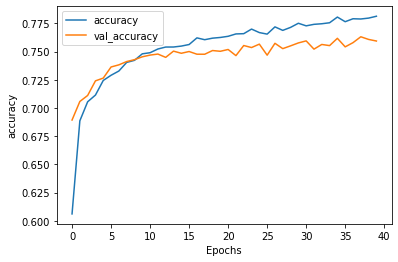

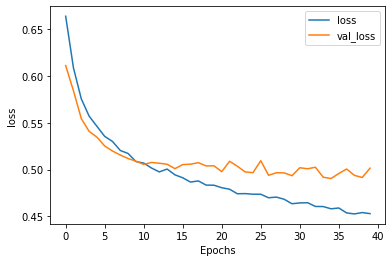

In [37]:
num_epochs = 40
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels),batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## GRUs
<a href="#toc" id="4b">Table Of Contents</a>

In [38]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, embedding_dim, weights = [embedding_matrix], input_length=max_length, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
#     tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 300)          5128800   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 150, 64)           64128     
_________________________________________________________________
dense_10 (Dense)             (None, 150, 1)            65        
Total params: 5,192,993
Trainable params: 5,192,993
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
334/334 - 9s - loss: 0.6846 - accuracy: 0.5636 - val_loss: 0.6816 - val_accuracy: 0.5698
Epoch 2/40
334/334 - 6s - loss: 0.6428 - accuracy: 0.6333 - val_loss: 0.5916 - val_accuracy: 0.7011
Epoch 3/40
334/334 - 6s - loss: 0.5862 - accuracy: 0.7081 - val_loss: 0.5732 - val_accuracy: 0.7142
Epoch 4/40
334/334 - 6s - loss: 0.5697 - accuracy: 0.7180 - val_loss: 0.5523 - val_accuracy: 0.7332
Epoch 5/40
334/334 - 6s - loss: 0.5557 - accuracy: 0.7288 - val_loss: 0.5418 - val_accuracy: 0.7372
Epoch 6/40
334/334 - 6s - loss: 0.5467 - accuracy: 0.7324 - val_loss: 0.5340 - val_accuracy: 0.7402
Epoch 7/40
334/334 - 6s - loss: 0.5340 - accuracy: 0.7386 - val_loss: 0.5263 - val_accuracy: 0.7413
Epoch 8/40
334/334 - 6s - loss: 0.5229 - accuracy: 0.7459 - val_loss: 0.5199 - val_accuracy: 0.7434
Epoch 9/40
334/334 - 6s - loss: 0.5194 - accuracy: 0.7461 - val_loss: 0.5228 - val_accuracy: 0.7350
Epoch 10/40
334/334 - 6s - loss: 0.5161 - accuracy: 0.7461 - val_loss: 0.5129 - val_accuracy: 0.7463

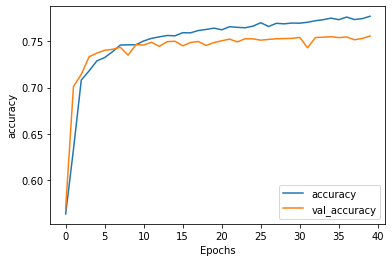

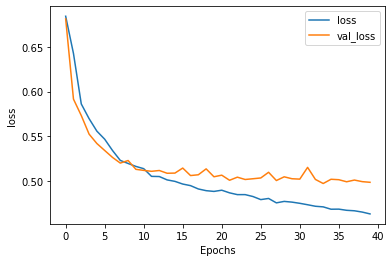

In [39]:
num_epochs = 40
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels),batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# **GloVe pre-trained static embedding on Twitter data - without STEMMING**

The quality of embeddings is crucial for the performance: we tried another set of pretrained embedding, of dimension 200 instead of 300 but trained on Twitter data.
Since these embeddings may be similar to the dataset we are evaluating, they may lead to a better performance.

## **LSTMs**
<a href="#toc" id="4c">Table Of Contents</a>

**import GloVe static embedding pre trained on twitter data with 200 dimension**

In [40]:

# load the GloVe embedding into memory 
import numpy as np
twitter_embeddings_index = dict()
f = open("../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt")



for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    twitter_embeddings_index[word] = coefs 
    
f.close()
print('Loaded %s word vectors.' %len(twitter_embeddings_index))


# create the weight matrix 
missing=0
twitter_embedding_matrix = np.zeros((len(tokenizer.word_index.items()) + 1, 200))

for word, i in tokenizer.word_index.items():
    twitter_embedding_vector = twitter_embeddings_index.get(word)
    if twitter_embedding_vector is not None: 
        twitter_embedding_matrix[i] = twitter_embedding_vector
    else:
        missing = missing + 1
print('%d embeddings are missing' %missing)


Loaded 1193514 word vectors.
5298 embeddings are missing


**LSTMs model definition**

In [41]:

import tensorflow as tf
from tensorflow import keras
twitter_embedding_dim = 200
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, twitter_embedding_dim, weights = [twitter_embedding_matrix], input_length=max_length, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, twitter_embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 150, 200)          3419200   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 150, 64)           59648     
_________________________________________________________________
dense_11 (Dense)             (None, 150, 24)           1560      
_________________________________________________________________
dense_12 (Dense)             (None, 150, 1)            25        
Total params: 3,480,433
Trainable params: 3,480,433
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
334/334 - 9s - loss: 0.6769 - accuracy: 0.5798 - val_loss: 0.6230 - val_accuracy: 0.6731
Epoch 2/40
334/334 - 5s - loss: 0.6131 - accuracy: 0.6731 - val_loss: 0.5856 - val_accuracy: 0.7009
Epoch 3/40
334/334 - 6s - loss: 0.5887 - accuracy: 0.6913 - val_loss: 0.5630 - val_accuracy: 0.7123
Epoch 4/40
334/334 - 5s - loss: 0.5708 - accuracy: 0.7016 - val_loss: 0.5511 - val_accuracy: 0.7164
Epoch 5/40
334/334 - 6s - loss: 0.5582 - accuracy: 0.7131 - val_loss: 0.5404 - val_accuracy: 0.7241
Epoch 6/40
334/334 - 5s - loss: 0.5492 - accuracy: 0.7178 - val_loss: 0.5299 - val_accuracy: 0.7334
Epoch 7/40
334/334 - 6s - loss: 0.5444 - accuracy: 0.7165 - val_loss: 0.5260 - val_accuracy: 0.7370
Epoch 8/40
334/334 - 5s - loss: 0.5353 - accuracy: 0.7274 - val_loss: 0.5257 - val_accuracy: 0.7379
Epoch 9/40
334/334 - 6s - loss: 0.5328 - accuracy: 0.7304 - val_loss: 0.5204 - val_accuracy: 0.7361
Epoch 10/40
334/334 - 6s - loss: 0.5255 - accuracy: 0.7324 - val_loss: 0.5163 - val_accuracy: 0.7410

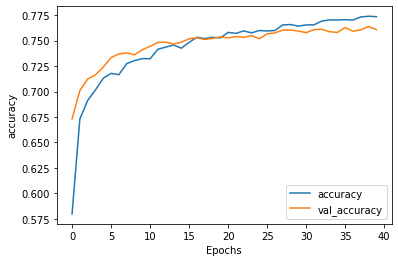

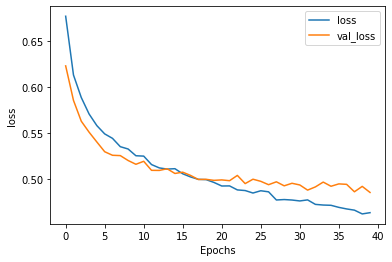

In [42]:
num_epochs = 40
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels),batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## GRUs
<a href="#toc" id="4d">Table Of Contents</a>

In [43]:
import tensorflow as tf
import keras
twitter_embedding_dim = 200
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, twitter_embedding_dim, weights = [twitter_embedding_matrix], input_length=max_length, trainable=True),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True,input_shape=(max_length, twitter_embedding_dim))),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 200)          3419200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 150, 64)           44928     
_________________________________________________________________
dense_13 (Dense)             (None, 150, 24)           1560      
_________________________________________________________________
dense_14 (Dense)             (None, 150, 1)            25        
Total params: 3,465,713
Trainable params: 3,465,713
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
334/334 - 9s - loss: 0.6841 - accuracy: 0.5643 - val_loss: 0.6802 - val_accuracy: 0.5716
Epoch 2/40
334/334 - 5s - loss: 0.6292 - accuracy: 0.6557 - val_loss: 0.5847 - val_accuracy: 0.7193
Epoch 3/40
334/334 - 5s - loss: 0.5754 - accuracy: 0.7190 - val_loss: 0.5657 - val_accuracy: 0.7259
Epoch 4/40
334/334 - 5s - loss: 0.4616 - accuracy: 0.7795 - val_loss: 0.4906 - val_accuracy: 0.7619
Epoch 26/40
334/334 - 5s - loss: 0.4603 - accuracy: 0.7786 - val_loss: 0.5125 - val_accuracy: 0.7517
Epoch 27/40
334/334 - 5s - loss: 0.4580 - accuracy: 0.7778 - val_loss: 0.4980 - val_accuracy: 0.7559
Epoch 28/40
334/334 - 5s - loss: 0.4568 - accuracy: 0.7800 - val_loss: 0.4882 - val_accuracy: 0.7613
Epoch 29/40
334/334 - 5s - loss: 0.4543 - accuracy: 0.7834 - val_loss: 0.5037 - val_accuracy: 0.7481
Epoch 30/40
334/334 - 5s - loss: 0.4535 - accuracy: 0.7850 - val_loss: 0.4985 - val_accuracy: 0.7626
Epoch 31/40
334/334 - 5s - loss: 0.4511 - accuracy: 0.7845 - val_loss: 0.4897 - val_accuracy: 0

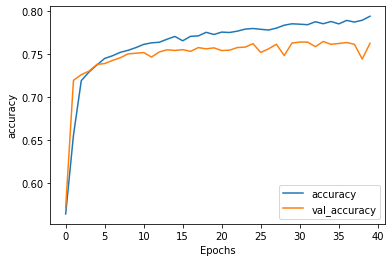

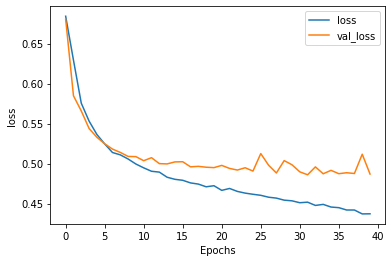

In [44]:
num_epochs = 40
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels),batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Contextual Embeddings
<a href="#toc" id="5">Table Of Contents</a>

In [1]:
from transformers import BertTokenizer, TFBertModel
from tqdm.notebook import tqdm

import tensorflow_hub as hub

# bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

2022-07-22 15:04:21.207729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 15:04:21.208773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 15:04:21.209430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 15:04:21.210320: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
max_length = 150

sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,truncation=True,max_length =max_length,
return_attention_mask = True)
tokenized_sequence

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [3]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP]'

In [21]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

def bert_encode(data, max_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

def create_bert(bert_model,max_length):
    
    input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
model = create_bert(bert_model,max_length)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     multiple             109482240   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           24608       tf_bert_model[1][1]        

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
input_ids=[]
attention_masks=[]

for sent in X:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,truncation=True,max_length =max_length,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
y=np.array(y)

# train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,y,attention_masks,test_size=0.2)

In [24]:
import tensorflow as tf
import keras

# callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir),tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]
# history=model.fit([train_inp,train_mask],train_label,batch_size=BATCH_SIZE,epochs=10,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks,verbose=2)

history = model.fit(
    [input_ids, attention_masks],
    y,
    validation_split=0.2, 
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=2
)

Epoch 1/10
334/334 - 92s - loss: 0.5922 - accuracy: 0.6781 - val_loss: 0.4659 - val_accuracy: 0.7821
Epoch 2/10
334/334 - 75s - loss: 0.4403 - accuracy: 0.8056 - val_loss: 0.4200 - val_accuracy: 0.8016
Epoch 3/10
334/334 - 75s - loss: 0.3450 - accuracy: 0.8578 - val_loss: 0.4109 - val_accuracy: 0.8130
Epoch 4/10
334/334 - 75s - loss: 0.2655 - accuracy: 0.8975 - val_loss: 0.4360 - val_accuracy: 0.8134
Epoch 5/10
334/334 - 75s - loss: 0.1953 - accuracy: 0.9308 - val_loss: 0.5395 - val_accuracy: 0.8199
Epoch 6/10
334/334 - 75s - loss: 0.1425 - accuracy: 0.9512 - val_loss: 0.5436 - val_accuracy: 0.8165
Epoch 7/10
334/334 - 75s - loss: 0.1079 - accuracy: 0.9639 - val_loss: 0.7423 - val_accuracy: 0.8137
Epoch 8/10
334/334 - 75s - loss: 0.0758 - accuracy: 0.9770 - val_loss: 0.6872 - val_accuracy: 0.8233
Epoch 9/10
334/334 - 75s - loss: 0.0619 - accuracy: 0.9810 - val_loss: 0.7601 - val_accuracy: 0.8276
Epoch 10/10
334/334 - 75s - loss: 0.0490 - accuracy: 0.9861 - val_loss: 0.8832 - val_accura

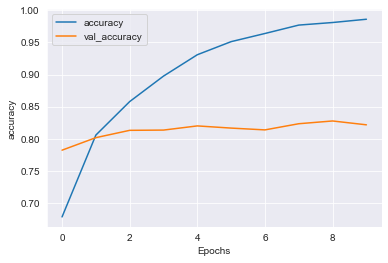

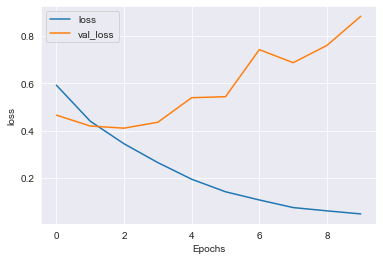

In [9]:
import matplotlib.pyplot as plt
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")